# SELF HEATING SYSTEM

We aim to resolve the problem of having a comfortable room temperature keeping into account the temperature sensed, the humidity and the human perception (cold, hot, etc)

# First step following tutorial 1: fuzzy variables

We can use the `skfuzzy` control system API to model this. First, let’s define the fuzzy variables.


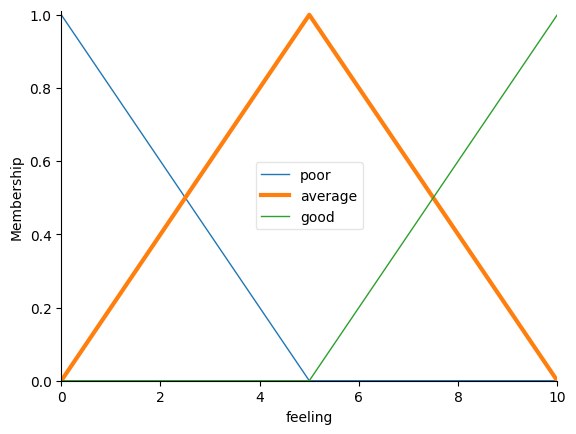

In [61]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# New Antecedent/Consequent objects hold universe variables and membership
# functions
degrees = ctrl.Antecedent(np.arange(0, 41, 1), 'degrees')
temp = ctrl.Consequent(np.arange(0, 41, 1), 'temperature')
humidity = ctrl.Antecedent(np.arange(0, 101, 1), 'humidity')
feeling = ctrl.Antecedent(np.arange(0, 11, 1), 'feeling')
hum =ctrl.Consequent(np.arange(0, 101, 1), 'humidifier')    #percentage

# Auto-membership function population is possible with .automf(3, 5, or 7)
feeling.automf(3)
humidity.automf(3)
degrees.automf(3)

# Custom membership functions can be built interactively with a familiar,
# Pythonic API
temp['low'] = fuzz.trimf(temp.universe, [0, 0, 20])
temp['medium'] = fuzz.trimf(temp.universe, [10, 20, 30])
temp['high'] = fuzz.trimf(temp.universe, [20, 40, 40])
hum['dehumidifies'] = fuzz.trimf(hum.universe, [0, 0, 50])
hum['okay'] = fuzz.trimf(hum.universe, [25, 50, 75])
hum['humidifies'] = fuzz.trimf(hum.universe, [50, 100, 100])

# You can see how these look with .view()
feeling['average'].view()

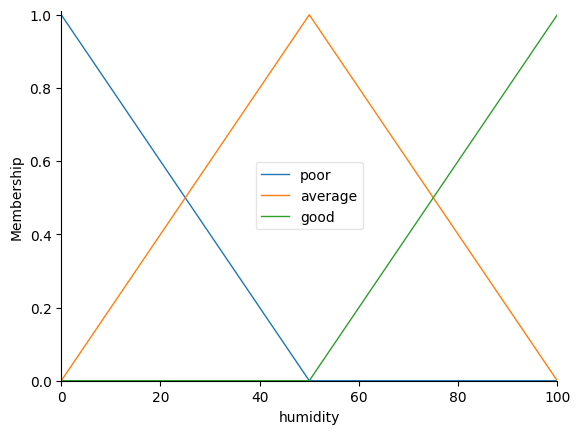

In [62]:
humidity.view()

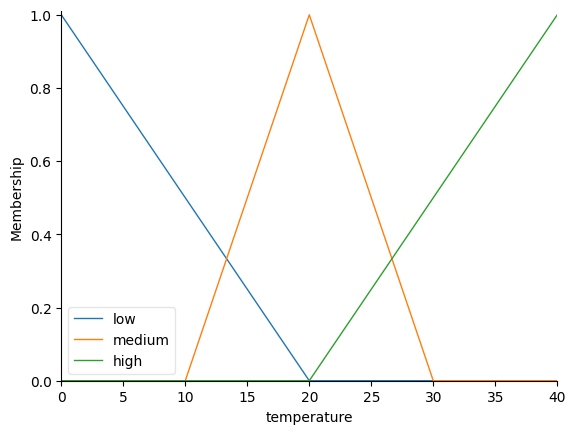

In [63]:
temp.view()

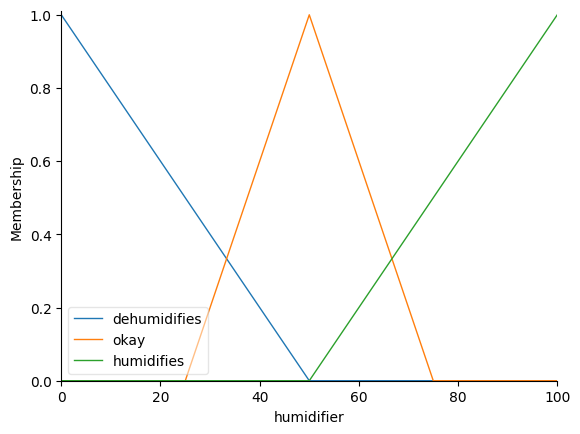

In [64]:
hum.view()

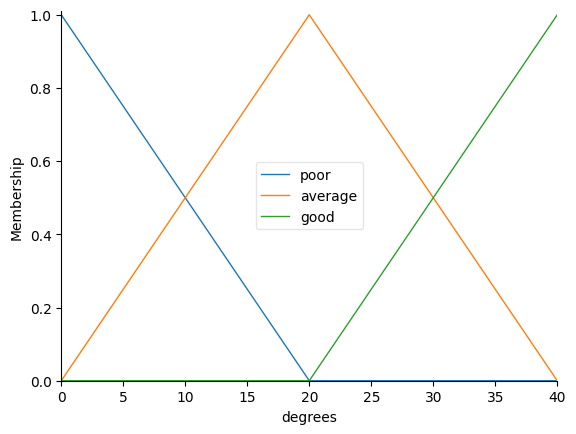

In [65]:
degrees.view()

# Step 2: Fuzzy Rules

Now, to make these triangles useful, we define the fuzzy relationship between input (degrees, humidity, feeling) and output (temperature of termostat, + humidifier ON/OFF) variables. 
We keep in mind that humidity affects perceived temperature by making it feel hotter in summer and colder in winter.

1. **If the feeling is hot (here 'good') OR the temperature is hot ('good'), then we set the termostat low.**
2. **If the humidity is high ('good'), then we want to dehumidify the room.**
3. **If the feeling is average we keep the termostat  medium**
4.  **If the feeling is cold ('poor') OR the temperature is low ('poor'), then we want to set the termostat high**
5.   **If the humidity is low ('poor'), then we want to humidify the room.**
6. **If the humidity is normal ('average'), then we keep the humidifier medium.**

(<Figure size 640x480 with 1 Axes>, <Axes: >)

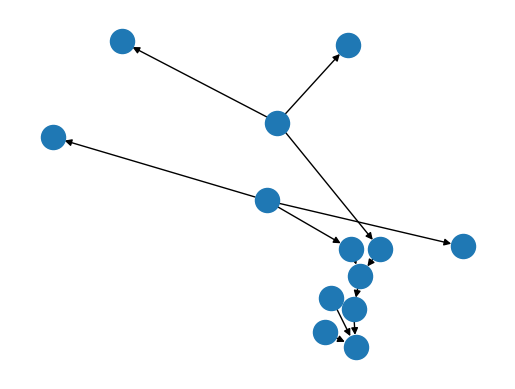

In [66]:
rule1 = ctrl.Rule(feeling['good'] | degrees['good'], temp['low'])
rule2 = ctrl.Rule( humidity['good'], hum['dehumidifies'])
rule3 = ctrl.Rule(feeling['average'], temp['medium'] )
rule4 = ctrl.Rule(feeling['poor'] | degrees['poor'], temp['high'])
rule5 = ctrl.Rule( humidity['poor'], hum['humidifies'])
rule6 = ctrl.Rule(humidity['average'], hum['okay'] )

rule1.view()

# Control System Creation and Simulation

Now that we have our rules defined, we can simply create a control system via:

In [67]:
heating_ctrl = ctrl.ControlSystem([rule1, rule3, rule4])
humidity_ctrl = ctrl.ControlSystem([rule2, rule5, rule6])


In [68]:
#we create a controller for each output

heating = ctrl.ControlSystemSimulation(heating_ctrl)
humidify = ctrl.ControlSystemSimulation(humidity_ctrl)

We test the controllers with a simulation

22.03655913978493


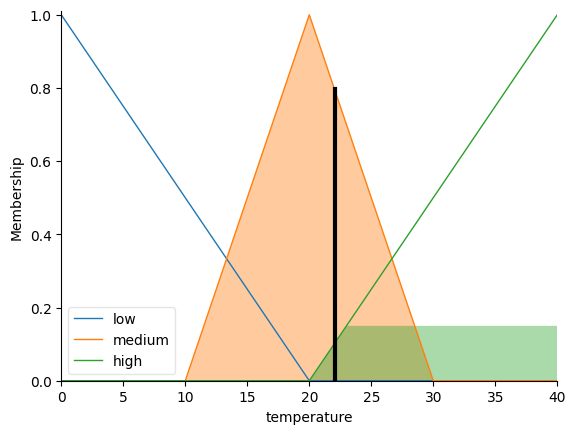

In [69]:
# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# Note: if you like passing many inputs all at once, use .inputs(dict_of_data)
heating.input['feeling'] = 5
heating.input['degrees'] = 17

# Crunch the numbers
heating.compute()

# Once computed, we can view the result as well as visualize it.

print(heating.output['temperature'])
temp.view(sim=heating)

38.47960444993818


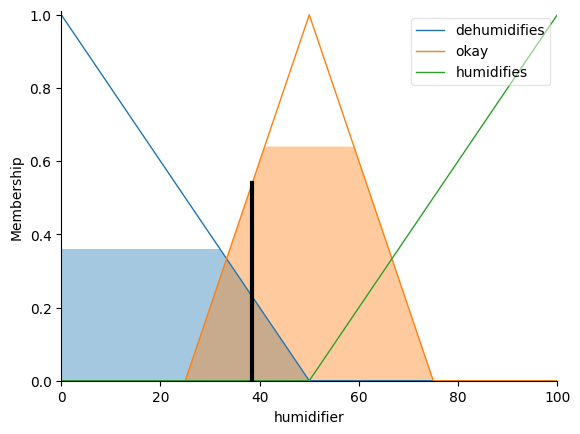

In [71]:
# Pass inputs to the ControlSystem using Antecedent labels with Pythonic API
# Note: if you like passing many inputs all at once, use .inputs(dict_of_data)
humidify.input['humidity'] = 68


# Crunch the numbers
humidify.compute()

# Once computed, we can view the result as well as visualize it.

print(humidify.output['humidifier'])
hum.view(sim=humidify)

# Defuzzification

let's try some defuzzification methods

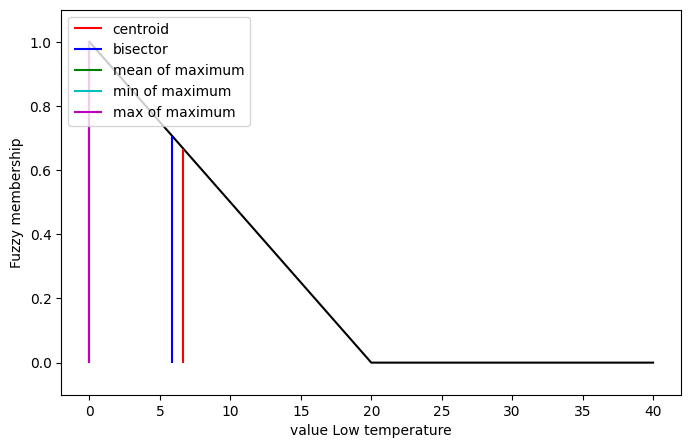

In [78]:
import matplotlib.pyplot as plt

#having the temperature membership function
#temp = ctrl.Consequent(np.arange(0, 41, 1), 'temperature')
#temp['low'] = fuzz.trimf(temp.universe, [0, 0, 20])
#temp['medium'] = fuzz.trimf(temp.universe, [10, 20, 30])
#temp['high'] = fuzz.trimf(temp.universe, [20, 40, 40])
x = temp.universe
mfx = fuzz.trimf(temp.universe, [0, 0, 20])  #array of mf with low temperature


defuzz_centroid = fuzz.defuzz(x, mfx, 'centroid')  # Same as skfuzzy.centroid
defuzz_bisector = fuzz.defuzz(x, mfx, 'bisector')
defuzz_mom = fuzz.defuzz(x, mfx, 'mom')
defuzz_som = fuzz.defuzz(x, mfx, 'som')
defuzz_lom = fuzz.defuzz(x, mfx, 'lom')

# Collect info for vertical lines
labels = ['centroid', 'bisector', 'mean of maximum', 'min of maximum',
          'max of maximum']
xvals = [defuzz_centroid,
         defuzz_bisector,
         defuzz_mom,
         defuzz_som,
         defuzz_lom]
colors = ['r', 'b', 'g', 'c', 'm']
ymax = [fuzz.interp_membership(x, mfx, i) for i in xvals]

# Display and compare defuzzification results against membership function
plt.figure(figsize=(8, 5))

plt.plot(x, mfx, 'k')
for xv, y, label, color in zip(xvals, ymax, labels, colors):
    plt.vlines(xv, 0, y, label=label, color=color)
plt.ylabel('Fuzzy membership')
plt.xlabel('value Low temperature')
plt.ylim(-0.1, 1.1)
plt.legend(loc=2)

plt.show()


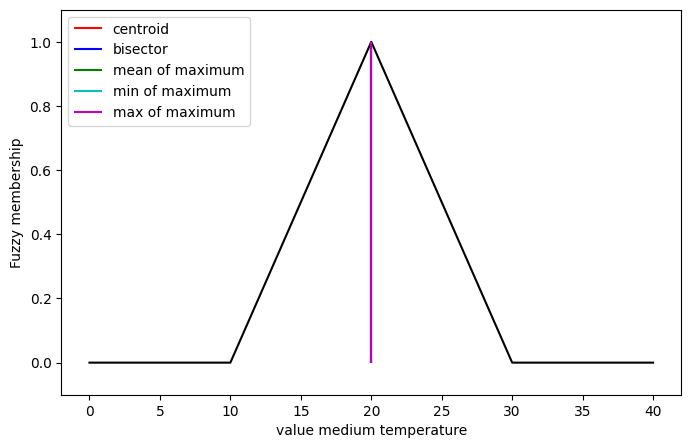

In [79]:
import matplotlib.pyplot as plt

#having the temperature membership function
#temp = ctrl.Consequent(np.arange(0, 41, 1), 'temperature')
#temp['low'] = fuzz.trimf(temp.universe, [0, 0, 20])
#temp['medium'] = fuzz.trimf(temp.universe, [10, 20, 30])
#temp['high'] = fuzz.trimf(temp.universe, [20, 40, 40])
x = temp.universe
mfx = fuzz.trimf(temp.universe, [10, 20, 30])


defuzz_centroid = fuzz.defuzz(x, mfx, 'centroid')  # Same as skfuzzy.centroid
defuzz_bisector = fuzz.defuzz(x, mfx, 'bisector')
defuzz_mom = fuzz.defuzz(x, mfx, 'mom')
defuzz_som = fuzz.defuzz(x, mfx, 'som')
defuzz_lom = fuzz.defuzz(x, mfx, 'lom')

# Collect info for vertical lines
labels = ['centroid', 'bisector', 'mean of maximum', 'min of maximum',
          'max of maximum']
xvals = [defuzz_centroid,
         defuzz_bisector,
         defuzz_mom,
         defuzz_som,
         defuzz_lom]
colors = ['r', 'b', 'g', 'c', 'm']
ymax = [fuzz.interp_membership(x, mfx, i) for i in xvals]

# Display and compare defuzzification results against membership function
plt.figure(figsize=(8, 5))

plt.plot(x, mfx, 'k')
for xv, y, label, color in zip(xvals, ymax, labels, colors):
    plt.vlines(xv, 0, y, label=label, color=color)
plt.ylabel('Fuzzy membership')
plt.xlabel('value medium temperature')
plt.ylim(-0.1, 1.1)
plt.legend(loc=2)

plt.show()


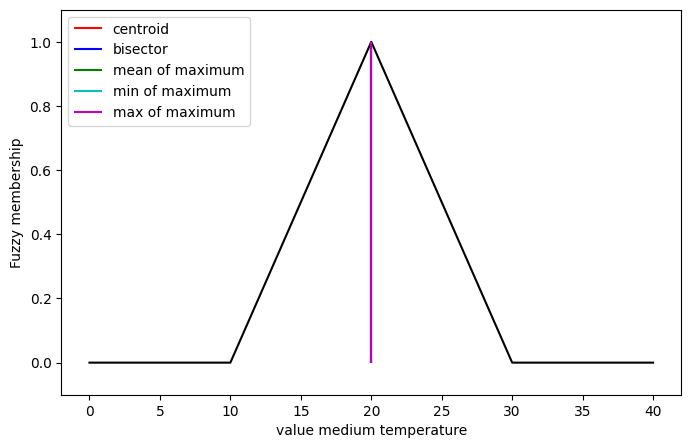

In [79]:
import matplotlib.pyplot as plt

#having the temperature membership function
#temp = ctrl.Consequent(np.arange(0, 41, 1), 'temperature')
#temp['low'] = fuzz.trimf(temp.universe, [0, 0, 20])
#temp['medium'] = fuzz.trimf(temp.universe, [10, 20, 30])
#temp['high'] = fuzz.trimf(temp.universe, [20, 40, 40])
x = temp.universe
mfx = fuzz.trimf(temp.universe, [10, 20, 30])


defuzz_centroid = fuzz.defuzz(x, mfx, 'centroid')  # Same as skfuzzy.centroid
defuzz_bisector = fuzz.defuzz(x, mfx, 'bisector')
defuzz_mom = fuzz.defuzz(x, mfx, 'mom')
defuzz_som = fuzz.defuzz(x, mfx, 'som')
defuzz_lom = fuzz.defuzz(x, mfx, 'lom')

# Collect info for vertical lines
labels = ['centroid', 'bisector', 'mean of maximum', 'min of maximum',
          'max of maximum']
xvals = [defuzz_centroid,
         defuzz_bisector,
         defuzz_mom,
         defuzz_som,
         defuzz_lom]
colors = ['r', 'b', 'g', 'c', 'm']
ymax = [fuzz.interp_membership(x, mfx, i) for i in xvals]

# Display and compare defuzzification results against membership function
plt.figure(figsize=(8, 5))

plt.plot(x, mfx, 'k')
for xv, y, label, color in zip(xvals, ymax, labels, colors):
    plt.vlines(xv, 0, y, label=label, color=color)
plt.ylabel('Fuzzy membership')
plt.xlabel('value high temperature')
plt.ylim(-0.1, 1.1)
plt.legend(loc=2)

plt.show()
